# Leaf Classification

The Leaf Classification Kaggle Competition offers an educational image training set of 99 leaves. The training data is comprised of an image set with 16 samples of each of 99 species of leaves, as well as 3 64-attribute vectors per leaf sample. The image data is first loaded and resized to 64x64 to ensure all images are of the same size for inputting into the convolutional neural network (CNN), and class labels are encoded for ease of data processing. The proposed CNN architechture is comprised of a convolutional input layer with 5x5 kernel and 16 filters, followed by a 2x2 MaxPooling layer and a 50% dropout to regularize the model and reduce overfitting. Afterwards, two convolutional layers with 32 filters each and 3x3 kernels are used in place of a 5x5 kernel to reduce parameters and computational requirements. Afterwards, another MaxPooling layer is added to further reduce dimensionality as well as the likelihood of overfitting. The data is then passed through a flattening layer before a fully connected dense layer and the subsequent output layer with a softmax activation function. 

The first model is tested with a batch size of 32, 10 epochs, and samples per epoch equal to the size of the training data (768). While this model resulted in a 98% accuracy on the training set, the validation set only reached 72% accuracy. Furthermore, a graphical comparison of loss and accuracy between the training and validation sets indicates overfitting. The lack of decrease in validation loss with subsequent epochs suggests this may be due to an overly high number of samples per epoch. To address this, a second model is proposed with samples per epoch equal to the size of the training data divided by batch size (24). The loss and accuracy functions for this second model confirm that a lower number of samples per epoch reduces overfitting, with validation and training curves showing little deviation from one another. However, the low number of epochs does not appear to be enough for the loss functions level off and the model resulted in a low accuracy of only 62% for training data and 53% for the validation. The third model explores this hypothesis by increasing the number of epochs from 10 to 30, while keeping all other parameters constant. Increasing the number of epochs succeeds in increasing model accuracy for both training and validation sets to 83% and 66% respectively. While this is better performing than the previous model, it does not yet surpass the first proposed model. For further hyperparameter tuning, a fourth model is implemented to balance the benefits of a lower number of samples found in model 2, with the higher accuracy resulting from more epochs. Model 4 is deployed with 15 epochs and 278 samples per epoch, resulting in a 97% training set accuracy and an 80% accuracy on the validation set. This final model was submitted to the Kaggle competition and received a score of  1.69522 based on the logloss scoring function. To further improve this model’s performance, additional action against overfitting is suggested. While regularization parameters where explored with minimal effect, increasing the training set through image rotation and translation may prove to be very beneficial.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import random

import cv2
from cv2 import imread, resize
import zipfile

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score, f1_score, precision_score, recall_score

from skimage.io import imread
from skimage.transform import resize, rotate, SimilarityTransform, warp
from skimage.filters import sobel
import glob

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from keras.constraints import max_norm, unit_norm

from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
train = pd.read_csv('../input/leaf-classification/train.csv.zip', usecols=['id', 'species'])
mtrain = train.shape[0]
test = pd.read_csv('../input/leaf-classification/test.csv.zip', usecols = [0])
mtest = test.shape[0]

In [5]:
# Resize and read images
# Fill image to same size
print('Loading and resizing images...')# % len(image_paths))
img_rows, img_cols = 64, 64 #96,96 #40, 40
output_shape = (img_rows, img_cols)

train_images = np.zeros((mtrain, img_rows, img_cols))
for i in range(mtrain):
    image = imread('../input/leaf-classification/images.zip/images/'+str(train.id.iloc[i])+'.jpg')
    rimage = resize(image, output_shape=output_shape)
    train_images[i] = sobel(rimage)
    
test_images = np.zeros((mtest, img_rows, img_cols))
for i in range(mtest):
    image = imread('../input/leaf-classification/images.zip/images/'+str(test.id.iloc[i])+'.jpg')
    rimage = resize(image, output_shape=output_shape)
    test_images[i] = sobel(rimage)

print('Train images shape: {}'.format(train_images.shape)) # 990
print('Test images shape: {}'.format(test_images.shape)) # 594

In [6]:
# Target
le = LabelEncoder()
target = le.fit_transform(train.species)
print("Target shape: {}".format(target.shape))
print(np.unique(target).size)
print(target[:5])

In [7]:
# Scale training data
#scaler = StandardScaler().fit(train_images)
#train_images = scaler.transform(train_images)

In [8]:
# Image batch generator
def imageGenerator(X, y, batch_size):
    img_rows, img_cols = X.shape[1], X.shape[2]
    resc = 0.02
    rot = 5
    transl = 0.01*img_rows
    while 1: # Infinite loop
        batchX = np.zeros((batch_size, img_rows, img_cols, 1))
        # batch_size random indices over train images
        batch_ids = np.random.choice(X.shape[0], batch_size)
        for j in range(batch_ids.shape[0]): # Loop over random images
            # Rotate around center
            imagej = rotate(X[batch_ids[j]], angle =rot*np.random.randn())
            # Rescale and translate
            tf = SimilarityTransform(scale = 1 + resc*np.random.randn(1,2)[0],
                                translation = transl*np.random.randn(1,2)[0]) 
            batchX[j] = warp(imagej, tf)
        #batchX = np.reshape(batchX, (batch_size,-1)) # Flattened images for FNN
        #print(batchX.shape, y[batch_ids].shape)
        yield (batchX, y[batch_ids])

# Model 1

Model Parameters:
Batch size: 32, epochs: 10, samples per epoch: 768, n classes: 99

In [236]:
# Create random train and validation sets out of 20% samples
Xtrain, Xval, ytrain, yval = train_test_split(train_images, target, test_size=0.20,
                                           stratify=target, random_state=14)

print('\nXtrain, ytrain shapes ' + str((Xtrain.shape, ytrain.shape)))
print('Xval, yval shapes ' + str((Xval.shape, yval.shape)))

# Reshape data as a 4-dim tensor [number samples, width, height, color channels]
print('Reshape as 4-dim tensor (Tensorflow backend)')
Xtrain = Xtrain.reshape(Xtrain.shape[0], img_rows, img_cols, 1) # 792
Xval = Xval.reshape(Xval.shape[0], img_rows, img_cols, 1) # 198
Xtest = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(Xtrain.shape, Xval.shape, Xtest.shape)

In [237]:
# Convolutional Neural Network
print('Train convolutional neural network')
# Parameters
# Batch size: number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need
batch_size = 32
# Epoch: one forward pass and one backward pass of all the training examples
nb_epoch = 10
n_extension = 1
samples_per_epoch = batch_size*(n_extension*Xtrain.shape[0] // batch_size)
#samples_per_epoch = (Xtrain.shape[0] // batch_size)

# number of convolutional filters to use (a hidden layer is segmented into feature maps
# where each unit in a feature map looks for the same feature but at different positions of the input image)
#nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
# Number of classes
nb_classes = np.unique(ytrain).size
#kernel_size = (5, 5)
print('Model Parameters:')
print('Batch size: %d, epochs: %d, samples per epoch: %d, n classes: %d' % 
                                (batch_size, nb_epoch,samples_per_epoch, nb_classes))

In [238]:
# Convert class vectors to binary class matrices (one-hot encoder)
ytrain = np_utils.to_categorical(ytrain, nb_classes)
yval = np_utils.to_categorical(yval, nb_classes)


# Create model
model = Sequential()

# Add hidden layers

# Conv2D layer with 5x5 kernels (local weights) and 16 conv filters 
# (or feature maps), expects 2d images as inputs
model.add(Conv2D(filters=16, kernel_size=(5,5),  padding='same', input_shape=input_shape,activation='relu',))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5)) # Regularization method, exclude 50% units

# Stack two 3x3 conv2D layers (Instead of one 5x5)
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape,activation='relu',))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape,activation='relu',))

# Pool2D layer, a form of non-linear down-sampling to prevent
# overfitting and provide a form of translation invariance
model.add(MaxPooling2D(pool_size=pool_size))

# Flattenig layer, converts 2D matrix into vectors
model.add(Flatten())

# Standard fully connected layer with 128 units
model.add(Dense(128))
model.add(Activation('relu'))

# Output layer
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [239]:

print('\nTraining Keras Convolutional Neural Network...')
# Fit model with generator
results = model.fit_generator(imageGenerator(Xtrain, ytrain, batch_size), 
                    steps_per_epoch = samples_per_epoch,
                    epochs=nb_epoch, verbose=1, validation_data=(Xval, yval))
#model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=nb_epoch,
#          verbose=1, validation_data=(Xval, yval))

In [240]:
score = model.evaluate(Xval, yval, verbose=0)
print('Validation loss: %0.5f' % score[0])
print('Validation accuracy: %0.2f' % (100*score[1]))

In [241]:
losses = pd.DataFrame(results.history)

losses.head()

In [242]:
#Ploting Loss Vs Val_Loss
losses[['loss','val_loss']].plot()

In [243]:
#Plotting  Accutacy vs Val_accuracy
losses[['accuracy','val_accuracy']].plot()

Number of Epochs and steps per epoch are sufficient to train model to 98% accuracy on training set, however the model exhibits overfitting as clearly indicated in the graph comparison of training and validation loss. While the training set's loss effectively decreases to 0, the validation loss essentially fails to decrease at all here possibly as a result of too many steps per epoch.

# Model 2

Reduced steps_per_epoch to Training_size/batch_size

Model Parameters:
Batch size: 32, epochs: 10, samples per epoch: 24, n classes: 99

In [244]:
# Create random train and validation sets out of 20% samples
Xtrain, Xval, ytrain, yval = train_test_split(train_images, target, test_size=0.20,
                                           stratify=target, random_state=14)

print('\nXtrain, ytrain shapes ' + str((Xtrain.shape, ytrain.shape)))
print('Xval, yval shapes ' + str((Xval.shape, yval.shape)))

# Reshape data as a 4-dim tensor [number samples, width, height, color channels]
print('Reshape as 4-dim tensor (Tensorflow backend)')
Xtrain = Xtrain.reshape(Xtrain.shape[0], img_rows, img_cols, 1) # 792
Xval = Xval.reshape(Xval.shape[0], img_rows, img_cols, 1) # 198
Xtest = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(Xtrain.shape, Xval.shape, Xtest.shape)

In [245]:
# Convolutional Neural Network
print('Train convolutional neural network')
# Parameters
# Batch size: number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need
batch_size = 32
# Epoch: one forward pass and one backward pass of all the training examples
nb_epoch = 10
n_extension = 1
#samples_per_epoch = batch_size*(n_extension*Xtrain.shape[0] // batch_size)
samples_per_epoch = Xtrain.shape[0] // batch_size

# number of convolutional filters to use (a hidden layer is segmented into feature maps
# where each unit in a feature map looks for the same feature but at different positions of the input image)
#nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
# Number of classes
nb_classes = np.unique(ytrain).size
#kernel_size = (5, 5)
print('Model Parameters:')
print('Batch size: %d, epochs: %d, samples per epoch: %d, n classes: %d' % 
                                (batch_size, nb_epoch,samples_per_epoch, nb_classes))

In [246]:
# Convert class vectors to binary class matrices (one-hot encoder)
ytrain = np_utils.to_categorical(ytrain, nb_classes)
yval = np_utils.to_categorical(yval, nb_classes)

# Create model
model2 = Sequential()

# Add hidden layers

# Conv2D layer with 5x5 kernels (local weights) and 16 conv filters 
# (or feature maps), expects 2d images as inputs
model2.add(Conv2D(filters=16, kernel_size=(5,5),kernel_initializer='he_normal',  padding='same', input_shape=input_shape,activation='relu',))
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(0.5)) # Regularization method, exclude 50% units

# Stack two 3x3 conv2D layers (Instead of one 5x5)
model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_regularizer=regularizers.l2(l=0.01), input_shape=input_shape,activation='relu',))
model2.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_regularizer=regularizers.l2(l=0.01), input_shape=input_shape,activation='relu',))

# Pool2D layer, a form of non-linear down-sampling to prevent
# overfitting and provide a form of translation invariance
model2.add(MaxPooling2D(pool_size=pool_size))

# Flattenig layer, converts 2D matrix into vectors
model2.add(Flatten())

# Standard fully connected layer with 128 units
model2.add(Dense(128))
model2.add(Activation('relu'))

# Output layer
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))

# Compile model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [247]:

print('\nTraining Keras Convolutional Neural Network...')
# Fit model with generator
results2 = model2.fit_generator(imageGenerator(Xtrain, ytrain, batch_size), 
                    steps_per_epoch = samples_per_epoch,
                    epochs=nb_epoch, verbose=1, validation_data=(Xval, yval))

In [248]:
score = model2.evaluate(Xval, yval, verbose=0)
print('Validation loss: %0.5f' % score[0])
print('Validation accuracy: %0.2f' % (100*score[1]))

In [249]:
losses = pd.DataFrame(results2.history)

losses.head()

In [250]:
#Ploting Loss Vs Val_Loss
losses[['loss','val_loss']].plot()

In [251]:
#Plotting  Accutacy vs Val_accuracy
losses[['accuracy','val_accuracy']].plot()

Reducing the number of steps per epoch helped to address the overfitting issue as observed in the loss graphs for training and validation sets, however the overall accuracy for training and validation sets are much lower than in the previous model.

# Model 3

Increase number of epochs since last model's loss did not appear to converge yet.

Model Parameters:
Batch size: 32, epochs: 30, samples per epoch: 24, n classes: 99

In [252]:
# Create random train and validation sets out of 20% samples
Xtrain, Xval, ytrain, yval = train_test_split(train_images, target, test_size=0.20,
                                           stratify=target, random_state=14)

print('\nXtrain, ytrain shapes ' + str((Xtrain.shape, ytrain.shape)))
print('Xval, yval shapes ' + str((Xval.shape, yval.shape)))

# Reshape data as a 4-dim tensor [number samples, width, height, color channels]
print('Reshape as 4-dim tensor (Tensorflow backend)')
Xtrain = Xtrain.reshape(Xtrain.shape[0], img_rows, img_cols, 1) # 792
Xval = Xval.reshape(Xval.shape[0], img_rows, img_cols, 1) # 198
Xtest = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(Xtrain.shape, Xval.shape, Xtest.shape)

In [253]:
# Convolutional Neural Network
print('Train convolutional neural network')
# Parameters
# Batch size: number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need
batch_size = 32
# Epoch: one forward pass and one backward pass of all the training examples
nb_epoch = 30
n_extension = 1
#samples_per_epoch = batch_size*(n_extension*Xtrain.shape[0] // batch_size)
samples_per_epoch = Xtrain.shape[0] // batch_size

# number of convolutional filters to use (a hidden layer is segmented into feature maps
# where each unit in a feature map looks for the same feature but at different positions of the input image)
#nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
# Number of classes
nb_classes = np.unique(ytrain).size
#kernel_size = (5, 5)
print('Model Parameters:')
print('Batch size: %d, epochs: %d, samples per epoch: %d, n classes: %d' % 
                                (batch_size, nb_epoch,samples_per_epoch, nb_classes))

In [254]:
# Convert class vectors to binary class matrices (one-hot encoder)
ytrain = np_utils.to_categorical(ytrain, nb_classes)
yval = np_utils.to_categorical(yval, nb_classes)

# Create model
model3 = Sequential()

# Add hidden layers

# Conv2D layer with 5x5 kernels (local weights) and 16 conv filters 
# (or feature maps), expects 2d images as inputs
model3.add(Conv2D(filters=16, kernel_size=(5,5),  padding='same', input_shape=input_shape,activation='relu',))
model3.add(MaxPooling2D(pool_size=pool_size))
model3.add(Dropout(0.5)) # Regularization method, exclude 50% units

# Stack two 3x3 conv2D layers (Instead of one 5x5)
model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=max_norm(3), bias_constraint=max_norm(3), input_shape=input_shape,activation='relu',))
model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=max_norm(3), bias_constraint=max_norm(3), input_shape=input_shape,activation='relu',))

# Pool2D layer, a form of non-linear down-sampling to prevent
# overfitting and provide a form of translation invariance
model3.add(MaxPooling2D(pool_size=pool_size))

# Flattenig layer, converts 2D matrix into vectors
model3.add(Flatten())

# Standard fully connected layer with 128 units
model3.add(Dense(128))
model3.add(Activation('relu'))

# Output layer
model3.add(Dense(nb_classes))
model3.add(Activation('softmax'))

# Compile model
model3.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [255]:
print('\nTraining Keras Convolutional Neural Network...')
# Fit model with generator
results3 = model3.fit_generator(imageGenerator(Xtrain, ytrain, batch_size), 
                    steps_per_epoch = samples_per_epoch,
                    epochs=nb_epoch, verbose=1, validation_data=(Xval, yval))

In [256]:
score = model3.evaluate(Xval, yval, verbose=0)
print('Validation loss: %0.5f' % score[0])
print('Validation accuracy: %0.2f' % (100*score[1]))

In [257]:
losses = pd.DataFrame(results3.history)
losses.head()

In [258]:
#Ploting Loss Vs Val_Loss
losses[['loss','val_loss']].plot()

In [259]:
#Plotting  Accutacy vs Val_accuracy
losses[['accuracy','val_accuracy']].plot()

Increasing number of epochs successfully increases accuracy score for both training and validation sets. The curves of loss and accuracy for training and validation appear to diverge after about 7 epochs, with the validation set leveling off around 65% accuracy.

# Model 4

Balances between the accuracy and fitting of models 2 and 3.

Model Parameters:
Batch size: 32, epochs: 15, samples per epoch: 278, n classes: 99

In [280]:
# Create random train and validation sets out of 10% samples
Xtrain, Xval, ytrain, yval = train_test_split(train_images, target, test_size=0.10,
                                           stratify=target, random_state=14)

#print('\nXtrain, ytrain shapes ' + str((Xtrain.shape, ytrain.shape)))
#print('Xval, yval shapes ' + str((Xval.shape, yval.shape)))

# Reshape data as a 4-dim tensor [number samples, width, height, color channels]
print('Reshape as 4-dim tensor (Tensorflow backend)')
Xtrain = Xtrain.reshape(Xtrain.shape[0], img_rows, img_cols, 1) # 792
Xval = Xval.reshape(Xval.shape[0], img_rows, img_cols, 1) # 198
Xtest = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(Xtrain.shape, Xval.shape, Xtest.shape)

In [281]:
# Convolutional Neural Network
print('Train convolutional neural network')
# Parameters
# Batch size: number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need
batch_size = 32
# Epoch: one forward pass and one backward pass of all the training examples
nb_epoch = 15
n_extension = 10
#samples_per_epoch = batch_size*(n_extension*Xtrain.shape[0] // batch_size)
samples_per_epoch = n_extension*Xtrain.shape[0] // batch_size

# number of convolutional filters to use (a hidden layer is segmented into feature maps
# where each unit in a feature map looks for the same feature but at different positions of the input image)
#nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
# Number of classes
nb_classes = np.unique(ytrain).size
#kernel_size = (5, 5)
print('Model Parameters:')
print('Batch size: %d, epochs: %d, samples per epoch: %d, n classes: %d' % 
                                (batch_size, nb_epoch,samples_per_epoch, nb_classes))

In [282]:
# Convert class vectors to binary class matrices (one-hot encoder)
ytrain = np_utils.to_categorical(ytrain, nb_classes)
yval = np_utils.to_categorical(yval, nb_classes)

# Create model
model4 = Sequential()

# Add hidden layers

# Conv2D layer with 5x5 kernels (local weights) and 16 conv filters 
# (or feature maps), expects 2d images as inputs
model4.add(Conv2D(filters=16, kernel_size=(5,5),  padding='same', input_shape=input_shape,activation='relu',))
model4.add(MaxPooling2D(pool_size=pool_size))
model4.add(Dropout(0.5)) # Regularization method, exclude 50% units

# Stack two 3x3 conv2D layers (Instead of one 5x5)
model4.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=max_norm(3), bias_constraint=max_norm(3), input_shape=input_shape,activation='relu',))
model4.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',kernel_constraint=max_norm(3), bias_constraint=max_norm(3), input_shape=input_shape,activation='relu',))

# Pool2D layer, a form of non-linear down-sampling to prevent
# overfitting and provide a form of translation invariance
model4.add(MaxPooling2D(pool_size=pool_size))

# Flattenig layer, converts 2D matrix into vectors
model4.add(Flatten())

# Standard fully connected layer with 128 units
model4.add(Dense(128))
model4.add(Activation('relu'))

# Output layer
model4.add(Dense(nb_classes))
model4.add(Activation('softmax'))

# Compile model
model4.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [283]:
print('\nTraining Keras Convolutional Neural Network...')
# Fit model with generator
results4 = model4.fit_generator(imageGenerator(Xtrain, ytrain, batch_size), 
                    steps_per_epoch = samples_per_epoch,
                    epochs=nb_epoch, verbose=1, validation_data=(Xval, yval))

In [284]:
score = model4.evaluate(Xval, yval, verbose=0)
print('Validation loss: %0.5f' % score[0])
print('Validation accuracy: %0.2f' % (100*score[1]))

In [285]:
losses = pd.DataFrame(results4.history)
losses.head()

In [286]:
#Ploting Loss Vs Val_Loss
losses[['loss','val_loss']].plot()

In [287]:
#Plotting  Accutacy vs Val_accuracy
losses[['accuracy','val_accuracy']].plot()

Successfully balances Model2 and Model3 by reducing the overfitting observed in Model2 with decreased steps per epoch, while also increasing accuracy with a greater number of epochs.

In [268]:
# Test predictions
print('Test predictions...')
ids = test.id
preds = model4.predict(Xtest)

# Submit
submission = pd.DataFrame(preds,index=ids,columns=le.classes_)
submission.to_csv('Leaf_Predictions_CNN_model4.csv')
submission.head()

## Final Model Prediction & Submission

In [273]:
Xtrain, ytrain = train_images, target
#Xval, yval = Xtrain, ytrain # Bigger validation set
print('\nXtrain, ytrain shapes ' + str((Xtrain.shape, ytrain.shape)))
#print('Xval, yval shapes ' + str((Xval.shape, yval.shape)))

In [274]:
# Reshape data as a 4-dim tensor [number samples, width, height, color channels]
print('Reshape as 4-dim tensor (Tensorflow backend)')
Xtrain = Xtrain.reshape(Xtrain.shape[0], img_rows, img_cols, 1) # 792
#Xval = Xval.reshape(Xval.shape[0], img_rows, img_cols, 1) # 198
Xtest = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
#print(Xtrain.shape, Xval.shape, Xtest.shape)
print(Xtrain.shape, Xtest.shape)

In [275]:
# Convolutional Neural Network
print('Train convolutional neural network')
# Parameters
# Batch size: number of training examples in one forward/backward pass. 
# The higher the batch size, the more memory space you'll need
batch_size = 32
# Epoch: one forward pass and one backward pass of all the training examples
nb_epoch = 15
n_extension = 10
#samples_per_epoch = batch_size*(n_extension*Xtrain.shape[0] // batch_size)
samples_per_epoch = n_extension*Xtrain.shape[0] // batch_size

# number of convolutional filters to use (a hidden layer is segmented into feature maps
# where each unit in a feature map looks for the same feature but at different positions of the input image)
#nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
# Number of classes
nb_classes = np.unique(ytrain).size
#kernel_size = (5, 5)
print('Model Parameters:')
print('Batch size: %d, epochs: %d, samples per epoch: %d, n classes: %d' % 
                                (batch_size, nb_epoch,samples_per_epoch, nb_classes))

In [276]:
# Convert class vectors to binary class matrices (one-hot encoder)
ytrain = np_utils.to_categorical(ytrain, nb_classes)
yval = np_utils.to_categorical(yval, nb_classes)


# Create model
final_model = Sequential()

# Add hidden layers

# Conv2D layer with 5x5 kernels (local weights) and 16 conv filters 
# (or feature maps), expects 2d images as inputs
final_model.add(Conv2D(filters=16, kernel_size=(5,5),  padding='same', input_shape=input_shape,activation='relu',))
final_model.add(MaxPooling2D(pool_size=pool_size))
final_model.add(Dropout(0.5)) # Regularization method, exclude 50% units

# Stack two 3x3 conv2D layers (Instead of one 5x5)
final_model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape,activation='relu',))
final_model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=input_shape,activation='relu',))

# Pool2D layer, a form of non-linear down-sampling to prevent
# overfitting and provide a form of translation invariance
final_model.add(MaxPooling2D(pool_size=pool_size))

# Flattenig layer, converts 2D matrix into vectors
final_model.add(Flatten())

# Standard fully connected layer with 128 units
final_model.add(Dense(128))
final_model.add(Activation('relu'))

# Output layer
final_model.add(Dense(nb_classes))
final_model.add(Activation('softmax'))

# Compile model
final_model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [277]:

print('\nTraining Keras Convolutional Neural Network...')
# Fit model with generator
results = final_model.fit_generator(imageGenerator(Xtrain, ytrain, batch_size), 
                    steps_per_epoch = samples_per_epoch,
                    epochs=nb_epoch, verbose=1)
#model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=nb_epoch,
#          verbose=1, validation_data=(Xval, yval))

In [279]:
# Test predictions
print('Test predictions...')
ids = test.id
preds = final_model.predict(Xtest)

# Submit
submission = pd.DataFrame(preds,index=ids,columns=le.classes_)
submission.to_csv('Leaf_Predictions_CNN.csv')
submission.head()

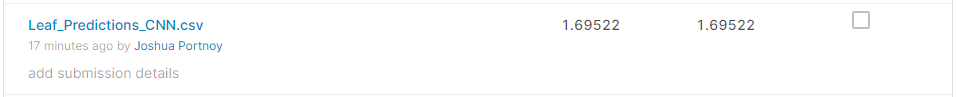